In [1]:
!pip install uproot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.4/392.4 kB 9.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.0/908.0 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 35.7 MB/s eta 0:00:00


In [2]:
!pip install uproot awkward vector numpy scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 4.1 MB/s eta 0:00:00a 0:00:01


In [4]:
import uproot
import awkward as ak
import numpy as np

# ===============================
# CONFIG
# ===============================
INPUT_ROOT  = "/kaggle/input/cms2011b-requiredbranches/merged.root"
OUTPUT_ROOT = "stageI_trigger.root"

# ===============================
# OPEN FILE
# ===============================
tree = uproot.open(INPUT_ROOT)["Events"]
branches = tree.keys()

# ===============================
# FIND TriggerResults
# ===============================
def find_branch_contains(token):
    matches = [b for b in branches if token in b]
    if len(matches) == 0:
        raise RuntimeError(f"Missing branch containing: {token}")
    if len(matches) > 1:
        print("⚠ Multiple matches found, using:", matches[0])
    return matches[0]

b_hlt = find_branch_contains("edmTriggerResults_TriggerResults__HLT")
print("✔ HLT TriggerResults branch resolved")

# ===============================
# LOAD ARRAYS
# ===============================
arrays = tree.arrays([b_hlt], library="ak")
hlt_pass_raw = arrays[b_hlt]

# ===============================
# BUILD FEATURES
# ===============================
# hlt_pass_raw is scalar bool per event
HLT_pass = ak.to_numpy(hlt_pass_raw).astype(np.int8)

# Path index NOT available in this dataset
HLT_path_index = np.full(len(HLT_pass), -1, dtype=np.int16)

# ===============================
# WRITE ROOT
# ===============================
with uproot.recreate(OUTPUT_ROOT) as fout:
    fout["Events"] = {
        "HLT_pass": HLT_pass,
        "HLT_path_index": HLT_path_index,
    }

print(f"\n✅ Stage-I Trigger ROOT written → {OUTPUT_ROOT}")


✔ HLT TriggerResults branch resolved

✅ Stage-I Trigger ROOT written → stageI_trigger.root


/tmp/ipykernel_47/3249591179.py:50: FutureWarning: Starting in version 5.7.0, Uproot will default to writing RNTuples instead of TTrees. You will need to use `mktree` to explicitly create a TTree. This can be done by changing `file['tree_name'] = data` to `file.mktree('tree_name', data)`. Please update your code accordingly.
  fout["Events"] = {



Total events: 452055
Available branches: ['HLT_pass', 'HLT_path_index']

Basic stats:
HLT_pass min/max: 1 1
HLT_path_index min/max: -1 -1

Physics sanity checks:
HLT_pass not in {0,1}: 0
HLT_path_index < 0: 452055

Event counts:
HLT passed: 452055
HLT failed: 0

HLT pass fraction: 1.0

Top 10 trigger paths by frequency:
Path  -1 : 452055


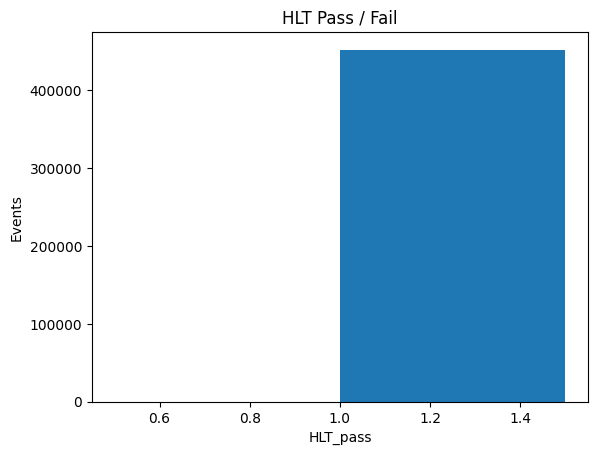

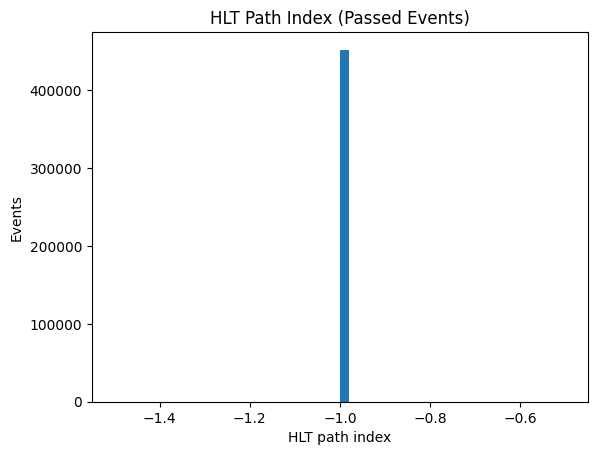


✔ Trigger EDA complete.


In [5]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------
# LOAD ROOT FILE
# ---------------------------------
f = uproot.open("/kaggle/working/stageI_trigger.root")  # adjust path if needed
tree = f["Events"]
arr = tree.arrays(library="ak")

print("\nTotal events:", len(arr))
print("Available branches:", list(arr.fields))

# ---------------------------------
# BASIC STATS
# ---------------------------------
print("\nBasic stats:")

print(
    "HLT_pass min/max:",
    ak.min(arr.HLT_pass),
    ak.max(arr.HLT_pass)
)

print(
    "HLT_path_index min/max:",
    ak.min(arr.HLT_path_index),
    ak.max(arr.HLT_path_index)
)

# ---------------------------------
# SANITY CHECKS
# ---------------------------------
print("\nPhysics sanity checks:")

print(
    "HLT_pass not in {0,1}:",
    ak.sum((arr.HLT_pass != 0) & (arr.HLT_pass != 1))
)

print(
    "HLT_path_index < 0:",
    ak.sum(arr.HLT_path_index < 0)
)

# ---------------------------------
# EVENT COUNTS
# ---------------------------------
passed = arr.HLT_pass == 1
failed = arr.HLT_pass == 0

print("\nEvent counts:")
print("HLT passed:", ak.sum(passed))
print("HLT failed:", ak.sum(failed))

# ---------------------------------
# HLT PASS RATE
# ---------------------------------
hlt_rate = ak.sum(passed) / len(arr)
print("\nHLT pass fraction:", float(hlt_rate))

# ---------------------------------
# PATH INDEX DISTRIBUTION (PASSED ONLY)
# ---------------------------------
passed_paths = arr.HLT_path_index[passed]

unique_paths, counts = np.unique(
    ak.to_numpy(passed_paths),
    return_counts=True
)

print("\nTop 10 trigger paths by frequency:")
for pid, cnt in sorted(
    zip(unique_paths, counts),
    key=lambda x: x[1],
    reverse=True
)[:10]:
    print(f"Path {pid:3d} : {cnt}")

# ---------------------------------
# HISTOGRAMS
# ---------------------------------

# 1) HLT_pass
plt.figure()
plt.hist(ak.to_numpy(arr.HLT_pass), bins=2)
plt.xlabel("HLT_pass")
plt.ylabel("Events")
plt.title("HLT Pass / Fail")
plt.show()

# 2) HLT_path_index (passed events only)
plt.figure()
plt.hist(ak.to_numpy(passed_paths), bins=50)
plt.xlabel("HLT path index")
plt.ylabel("Events")
plt.title("HLT Path Index (Passed Events)")
plt.show()

print("\n✔ Trigger EDA complete.")
